In [1]:
using Clustering
using MultivariateStats
using StatsBase
using CSV
using DataFrames
using CairoMakie
using GaussianMixtures
using SparseArrays

In [2]:
#=
4 taxa trees

One and four have the same structure but different branch lengths.
two and three have the same structure but different branch lengths

=#

tree_one = CSV.read("../../../data/one.csv", DataFrame);
tree_two = CSV.read("../../../data/two.csv", DataFrame);
tree_three = CSV.read("../../../data/three.csv", DataFrame);
tree_four = CSV.read("../../../data/four.csv", DataFrame);

In [3]:
function ground_true(df_1, df_2)
    a = fill(1,size(df_1)[1])
    b = fill(2,size(df_1)[1])
    gt = cat(a,b, dims = 1)
    return gt
end

# convert tree from dataframe to matrix. Each column is a tree
function standardize_tree(tree)    
    data = collect(Matrix(tree)');
    
    # standardize tree
    dt = fit(ZScoreTransform, data, dims=2)
    data = StatsBase.transform(dt, data)
    
    # replace NaN value with 0
    replace!(data, NaN=>0)
    return data
end

function plot_clusters(tree::AbstractMatrix{<:Real}, label::Vector{Int64})
    PCA_model = fit(PCA, tree, maxoutdim = 2);
    PCA_data = predict(PCA_model,tree)
    scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = label)
end

plot_clusters (generic function with 1 method)

In [4]:
using MLBase
using Hungarian

In [4]:
# Performance Check

function accuracy(n, gt, pred)
    matrix = confusmat(n, gt, pred)
    # Hungarian algorithm minimizes the cost, so we need to transform the matrix
    A = -matrix .+ maximum(matrix)    
    matrix = matrix[:,hungarian(A)[1]]
    x = tr(matrix)/sum(matrix)
    return matrix, x
end

accuracy (generic function with 1 method)

In [5]:
tree = CSV.read("../../../data/bipartition_4taxa_tree.csv", DataFrame);

In [6]:
# kmeans in Clustering.jl can only work on matix, and one tree per column
data = collect(Matrix(tree[:,:])');
# for row-wise standardization, set dims = 2
dt = fit(ZScoreTransform, data, dims=2)
data = StatsBase.transform(dt, data)
replace!(data, NaN=>0)

7×50000 Matrix{Float64}:
 -0.338843   0.546841   0.740266   …  -0.33034    -0.407648  -0.457926
 -0.333472  -0.678149  -0.0163795     -0.897146    0.496461  -0.308028
  0.327646  -0.503771   0.261475      -0.757011   -0.182455  -0.238909
  1.17469   -0.866192  -0.910438       0.0278396   0.314032   1.59743
  0.271627  -0.287401  -0.287401      -0.287401   -0.287401  -0.287401
 -0.457125  -0.457125  -0.457125   …  -0.457125    0.476502  -0.310249
 -0.463391   1.35842    0.0195581      0.139962   -0.463391  -0.463391

In [8]:
PCA_model = fit(PCA, data, maxoutdim = 2);
PCA_data = predict(PCA_model,data)

2×50000 Matrix{Float64}:
 -0.0179634  1.53635    0.618013  1.77922   …  0.580177  -0.922073  -0.162505
 -0.283743   0.499713  -0.316456  0.971234     0.670064   0.383719   0.58729

In [9]:
using Random
Random.seed!(0)
result = kmeans(data, 2);
counts(result)

2-element Vector{Int64}:
 41329
  8671

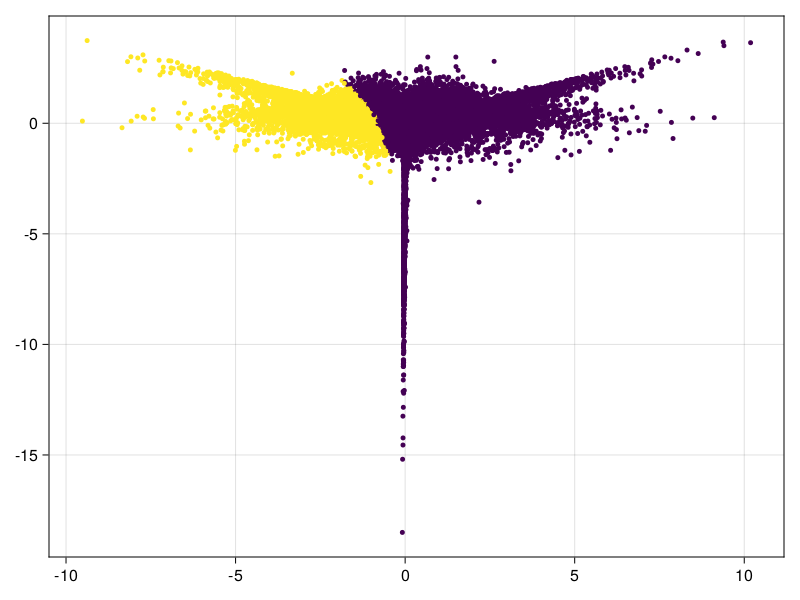

In [17]:
scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = result.assignments)

In [18]:
using ParallelKMeans

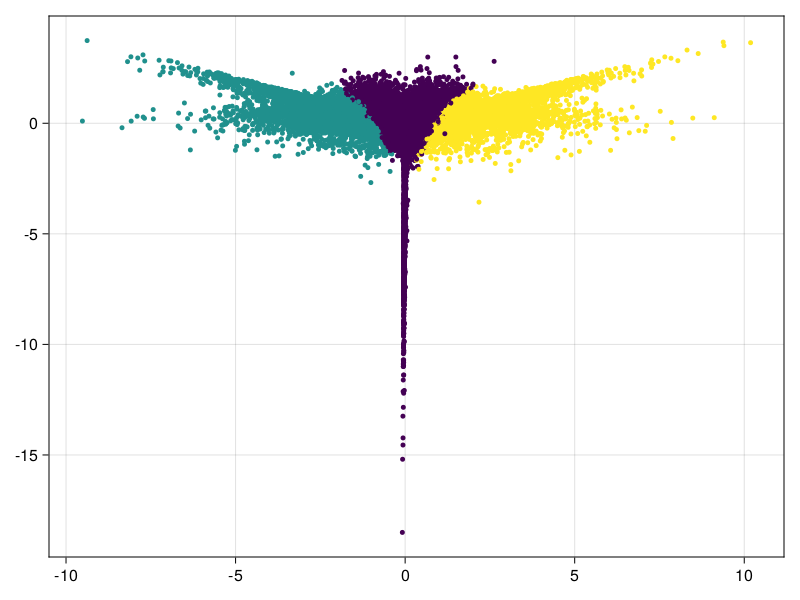

In [20]:
result = ParallelKMeans.kmeans(Hamerly(),data,3)
scatter(PCA_data[1,:], PCA_data[2,:], markersize = 5, color = result.assignments)

In [6]:
# n is the number of cluters
# remember standardize trees for better performance
function kmeans_label(tree, n; seed =:kmpp)  
    # apply kmeans clustering
    # init works like seed of random, Its length should be the same as the number of clusters    
    result = kmeans(tree, n, init = seed);
    return result.assignments
end;

# function kmeans_label(tree, n; seed =:"k-means++")
#     result = ParallelKMeans.kmeans(Elkan() , tree, n; k_init ="k-means++");
#     return result.assignments
# end

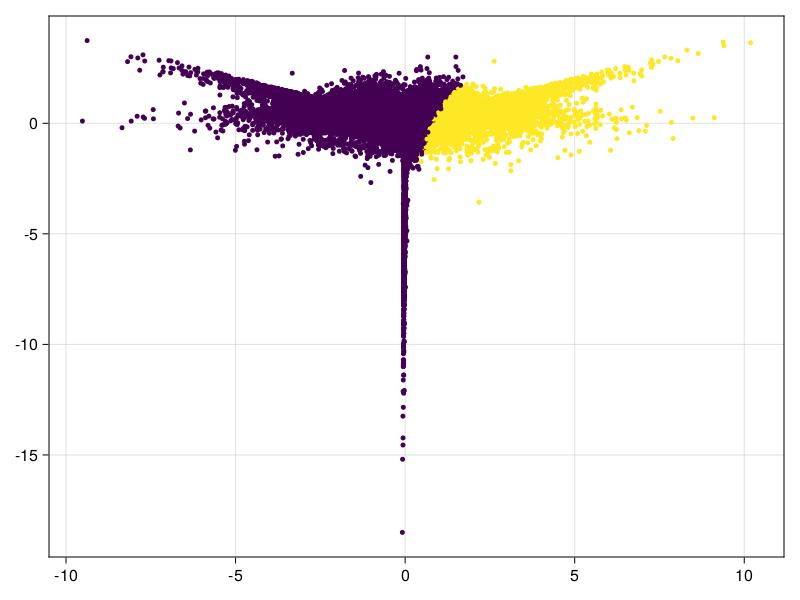

In [7]:
tree = CSV.read("../../../data/bipartition_4taxa_tree.csv", DataFrame);
tree = standardize_tree(tree)
label = kmeans_label(tree, 2,seed=[1,2])
plot_clusters(tree, label)

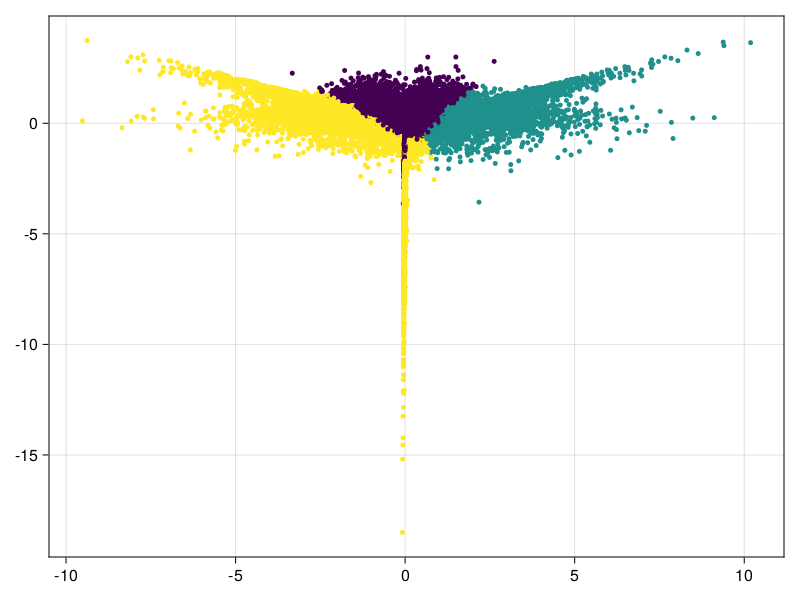

In [112]:
label = kmeans_label(tree, 3, seed =[1,2,3])
plot_clusters(tree, label)

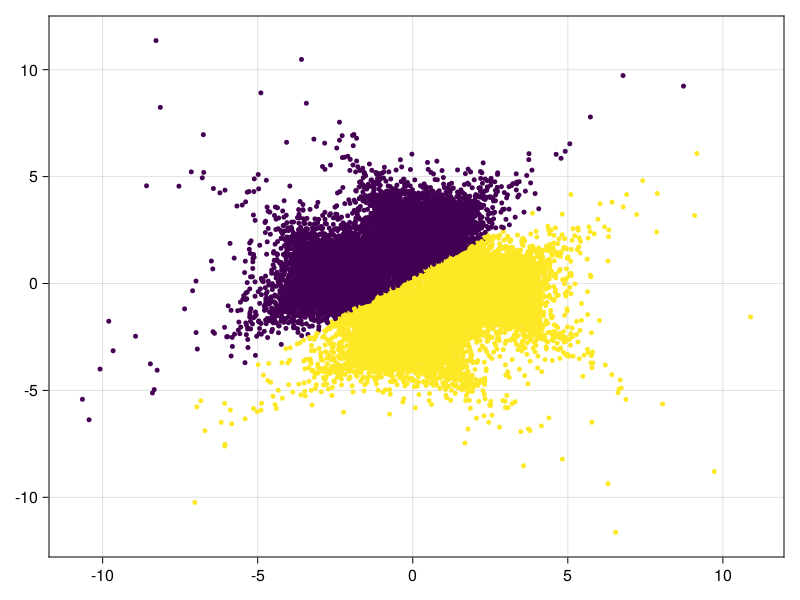

In [41]:
tree = CSV.read("../../../data/bipartition_8taxa_tree.csv", DataFrame);
tree = standardize_tree(tree)
label = kmeans_label(tree, 2, seed=[1,2])
plot_clusters(tree, label)

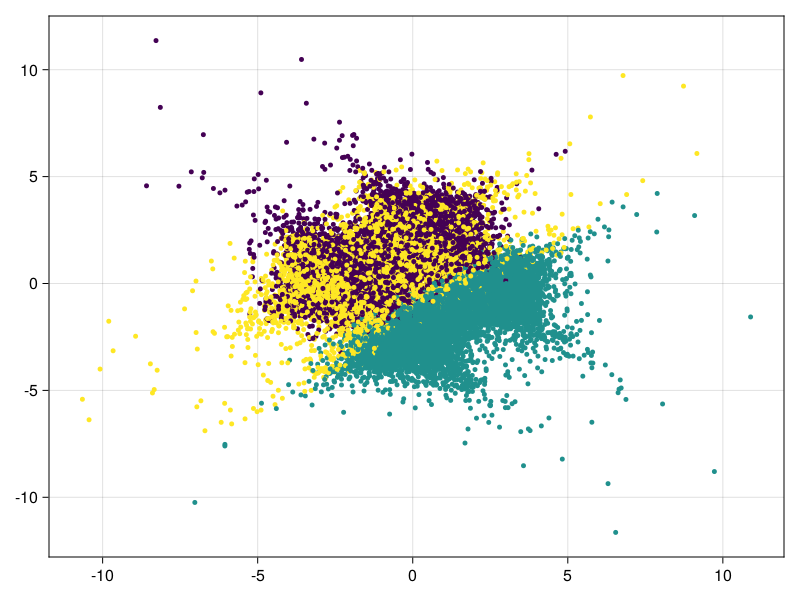

In [116]:
label = kmeans_label(tree, 3, seed=[1,2,3])
plot_clusters(tree, label)

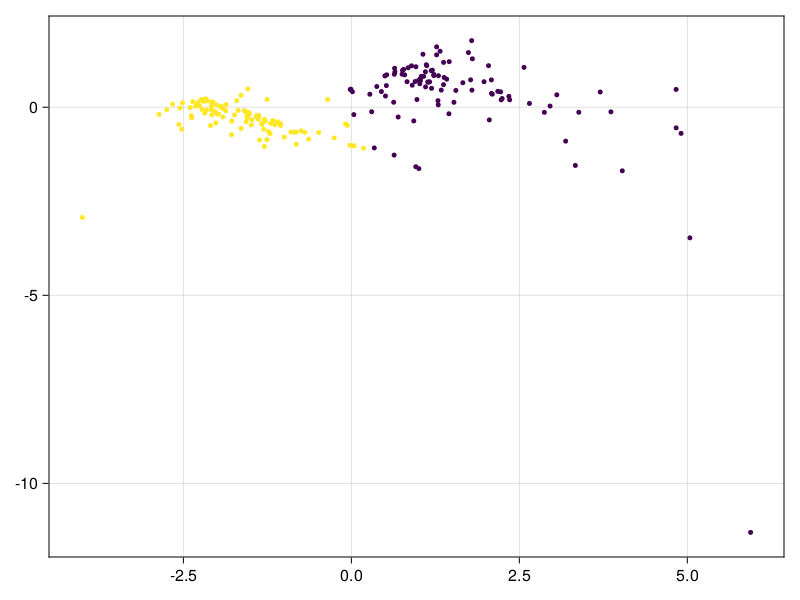

In [117]:
tree = vcat(tree_one ,tree_two)
tree = standardize_tree(tree)
label = kmeans_label(tree, 2, seed=[1,2])
plot_clusters(tree, label)

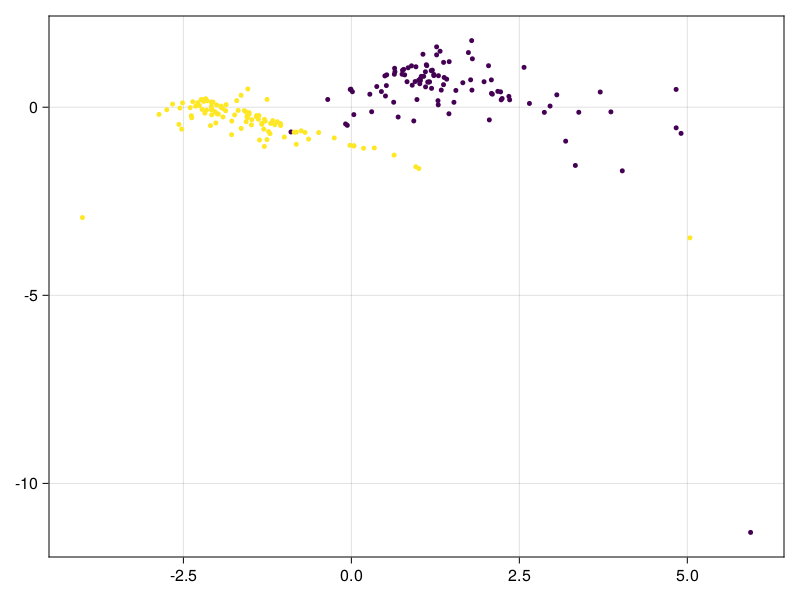

In [118]:
gt = ground_true(tree_one,tree_two)
plot_clusters(tree, gt)

In [124]:
gt = ground_true(tree_one,tree_two)
tree = vcat(tree_one ,tree_two)
tree = standardize_tree(tree)
pred = kmeans_label(tree, 2, seed=[1,2])
m,x = accuracy(2, gt, pred)
display(m)
print(x)

tree = vcat(tree_one ,tree_three)
tree = standardize_tree(tree)
pred = kmeans_label(tree, 2, seed=[1,2])
m,x = accuracy(2, gt, pred)
display(m)
print(x)

tree = vcat(tree_one ,tree_four)
tree = standardize_tree(tree)
pred = kmeans_label(tree, 2, seed=[2,2])
m,x = accuracy(2, gt, pred)
display(m)
print(x)


tree = vcat(tree_two,tree_three)
tree = standardize_tree(tree)
pred = kmeans_label(tree, 2, seed=[1,2])
m,x = accuracy(2, gt, pred)
display(m)
print(x)

2×2 Matrix{Int64}:
 96   4
  5  95

0.955

2×2 Matrix{Int64}:
 99   1
  3  97

0.98

2×2 Matrix{Int64}:
 27  73
 18  82

0.545

2×2 Matrix{Int64}:
 99   1
  2  98

0.985

In [13]:
function GMM_label(tree, n; method=:kmeans, kind=:diag)  
    data= Matrix(tree');
    gmm= GMM(n,data,method=method, kind=kind);
    prob_pos=gmmposterior(gmm,data)[1]
    llpg = gmmposterior(gmm,data)[2]
    llpg_result = map(argmax, eachrow(llpg))
    prob_result = map(argmax, eachrow(prob_pos))
    return prob_result, llpg_result
end;

In [14]:
# GMM
tree = CSV.read("../../../data/bipartition_4taxa_tree.csv", DataFrame);
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2, method=:split);

┌ Info: 0: avll = 
│   tll[1] = -1.418928533204724
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:156
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Info: 1
│   avll = [-1.419321694841083, -1.3713988138218107, -1.1722825747556638, -0.9482007825152792, -0.7790283931686117, -1.4113580549283604, -1.0396384376174557, -0.87011508918829, -1.0300976344847346, -1.2200013563959542]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:160
┌ Info: Total log likelihood: 
│   tll = [-1.418928533204724, -1.419321694841083, -1.3713988138

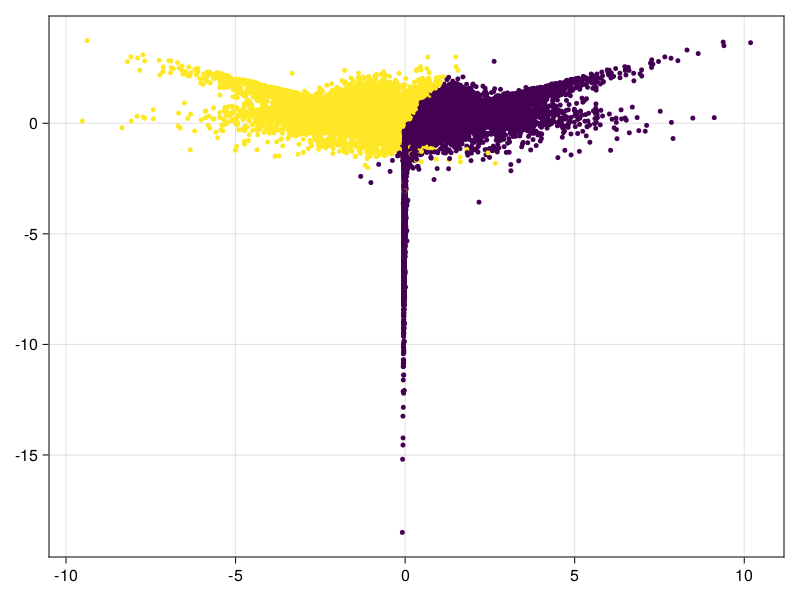

In [27]:
plot_clusters(tree, pred_prob)

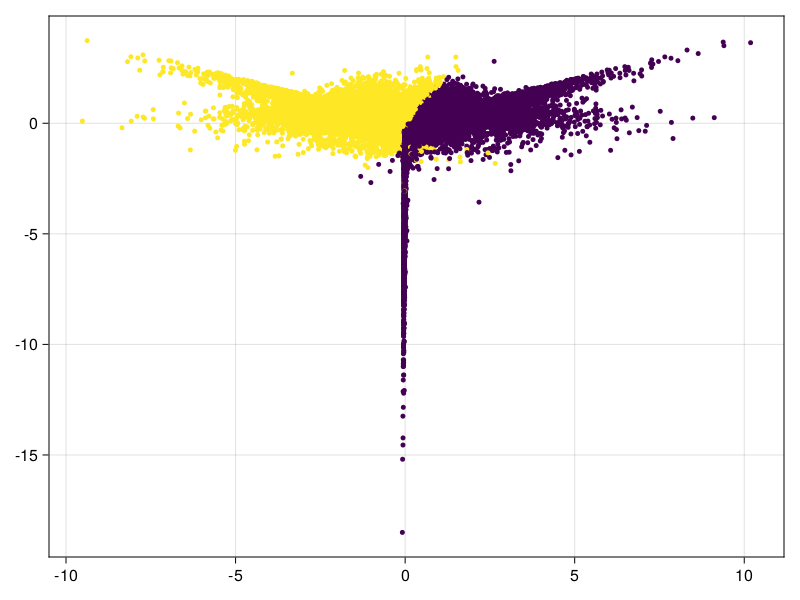

In [28]:
plot_clusters(tree, pred_llpg)

┌ Info: 0: avll = 
│   tll[1] = NaN
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:156
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 60 pathological elements normaliz

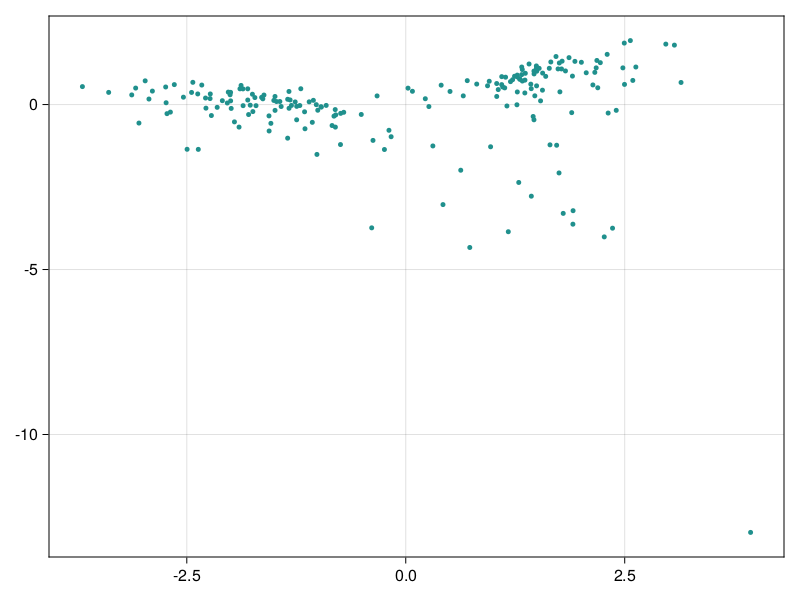

In [58]:
tree1 = CSV.read("data/5_one.csv", DataFrame);
tree2 = CSV.read("data/5_two.csv", DataFrame);
tree = vcat(tree1,tree2)
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2, method=:split);
plot_clusters(tree, pred_prob)

K-means converged with 3 iterations (objv = 72910.07595343412)


┌ Info: Initializing GMM, 2 Gaussians diag covariance 127 dimensions using 50000 data points
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:79
┌ Info: K-means with 2000 data points using 3 iterations
│ 7.8 data points per parameter
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:141
┌ Warning: 508 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 508 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 508 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 508 pathological elements normalized
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:69
┌ Warning: 508 pathological elements normalized
└ @ GaussianMixtures C:\Users\8

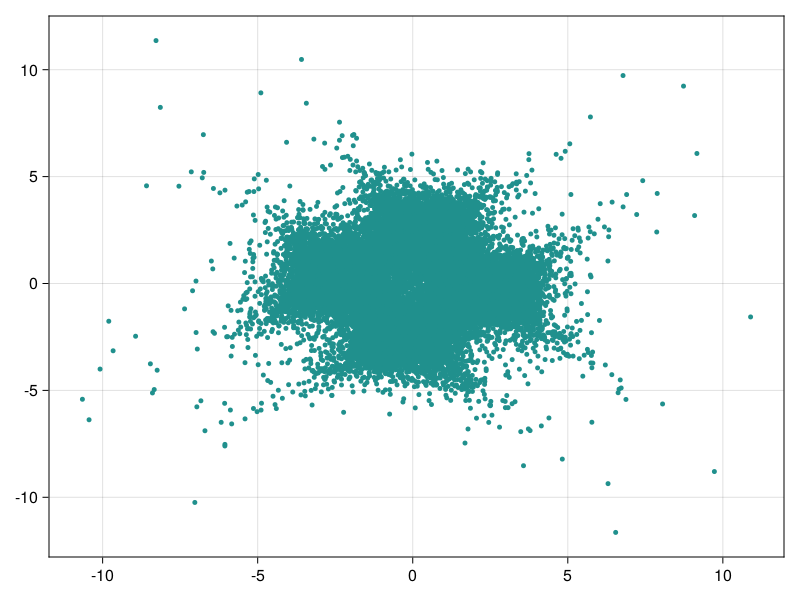

In [21]:
tree = CSV.read("../../../data/bipartition_8taxa_tree.csv", DataFrame);
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2);
plot_clusters(tree, pred_prob)

In [25]:
# GMM
tree = vcat(tree_one ,tree_two)
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2, method=:split);

┌ Info: 0: avll = 
│   tll[1] = -1.4164385332046725
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:156
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\

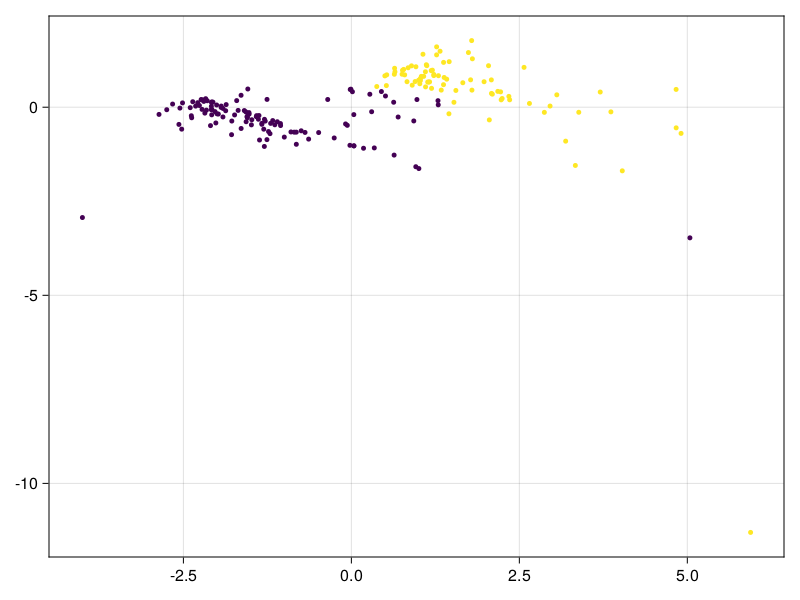

In [26]:
plot_clusters(tree,pred_llpg)

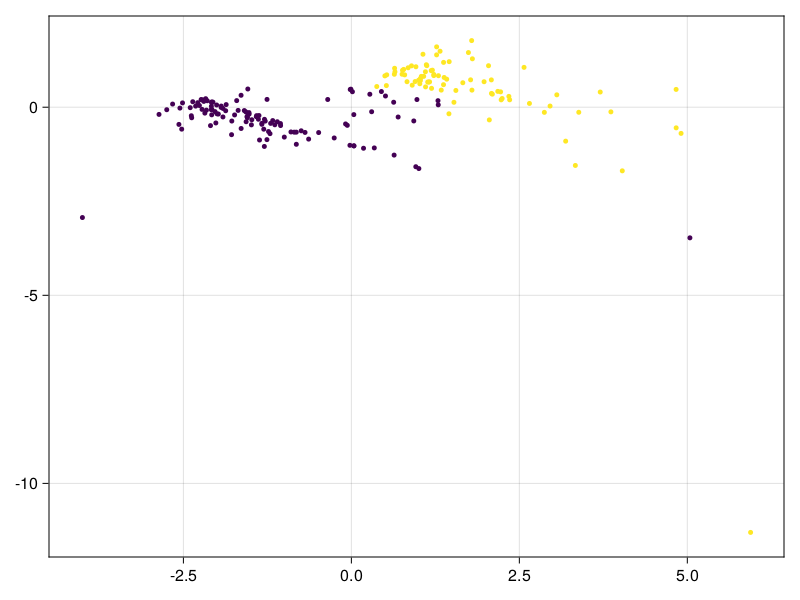

In [27]:
plot_clusters(tree, pred_prob)

In [28]:
gt = ground_true(tree_one,tree_two)
m,x = accuracy(2, gt, pred_llpg)
display(m)
print(x)

m,x = accuracy(2, gt, pred_prob)
display(m)
print(x)

2×2 Matrix{Int64}:
 82   18
  0  100

0.91

2×2 Matrix{Int64}:
 82   18
  0  100

0.91

In [29]:
tree = vcat(tree_one ,tree_four)
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2, method=:split);

gt = ground_true(tree_one,tree_four)
m,x = accuracy(2, gt, pred_prob)
display(m)
print(x)

m,x = accuracy(2, gt, pred_llpg)
display(m)
print(x)

┌ Info: 0: avll = 
│   tll[1] = -1.4164385332046734
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:156
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Info: 1
│   avll = [-1.417137919813217, -1.3060491593478432, -0.9552366297883452, -1.3122330187463482, -0.925725021333920

2×2 Matrix{Int64}:
 91   9
 84  16

0.535

2×2 Matrix{Int64}:
 91   9
 83  17

0.54

In [30]:
tree = vcat(tree_one ,tree_three)
tree = standardize_tree(tree)
pred_prob, pred_llpg = GMM_label(tree, 2, method=:split);

gt = ground_true(tree_one,tree_four)
m,x = accuracy(2, gt, pred_prob)
display(m)
print(x)

m,x = accuracy(2, gt, pred_llpg)
display(m)
print(x)

┌ Info: 0: avll = 
│   tll[1] = -1.4164385332046727
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:156
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDaBV\src\train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [2]
└ @ GaussianMixtures C:\Users\82537\.julia\packages\GaussianMixtures\zDa

2×2 Matrix{Int64}:
 98   2
  2  98

0.98

2×2 Matrix{Int64}:
 98   2
  2  98

0.98

In [31]:
# Density-based Spatial Clustering of Applications with Noise (DBSCAN)
tree = vcat(tree_one ,tree_two)
tree = standardize_tree(tree)
result = dbscan(tree,0.67, min_cluster_size = 70)

2-element Vector{DbscanCluster}:
 DbscanCluster(84, [2, 3, 5, 7, 8, 10, 11, 12, 13, 14  …  90, 91, 92, 93, 94, 96, 97, 98, 99, 100], Int64[])
 DbscanCluster(93, [22, 101, 102, 104, 105, 106, 107, 108, 109, 110  …  191, 192, 193, 194, 195, 196, 197, 198, 199, 200], Int64[])

In [32]:
# get only points in clusters
pred = getproperty.(result, :core_indices)
idx = fill(0,length(tree[1,:]))
for i in range(1, length(idx))
    if i in pred[1]
        idx[i] = 1
    elseif i in pred[2]
        idx[i] = 2
    end
end

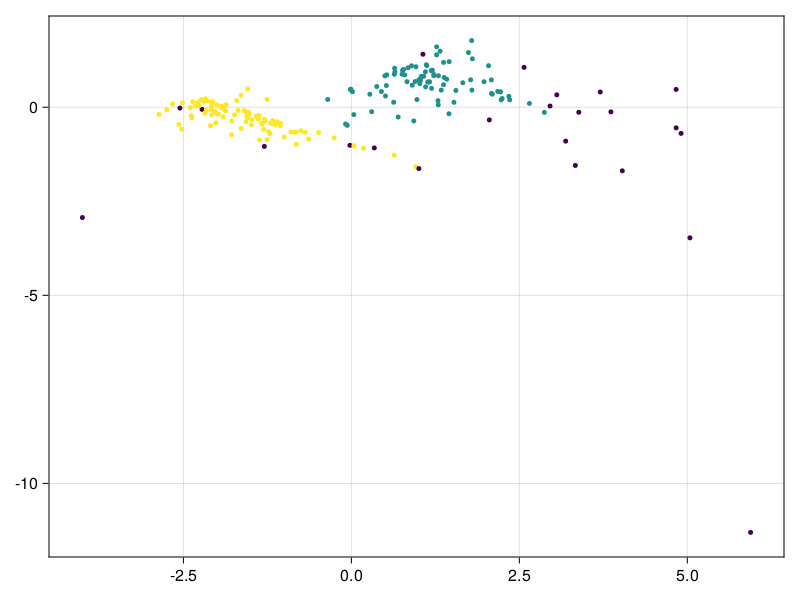

In [33]:
plot_clusters(tree, idx)

In [34]:
#function plot_dbscan(tree, radius, min_neighbors = 1, min_cluster_size = 1)
function dbscan_label(tree, radius; min_neighbors = 1, min_cluster_size = 1)   
    result = dbscan(tree, radius,min_neighbors = min_neighbors, min_cluster_size = min_cluster_size)   
    # get only points in clusters
    result = getproperty.(result, :core_indices)
    idx = fill(0,length(tree[1,:]))
    for i in range(1, length(idx))
        if i in result[1]
            idx[i] = 1
        elseif i in result[2]
            idx[i] = 2
        end
    end
    return idx
end;

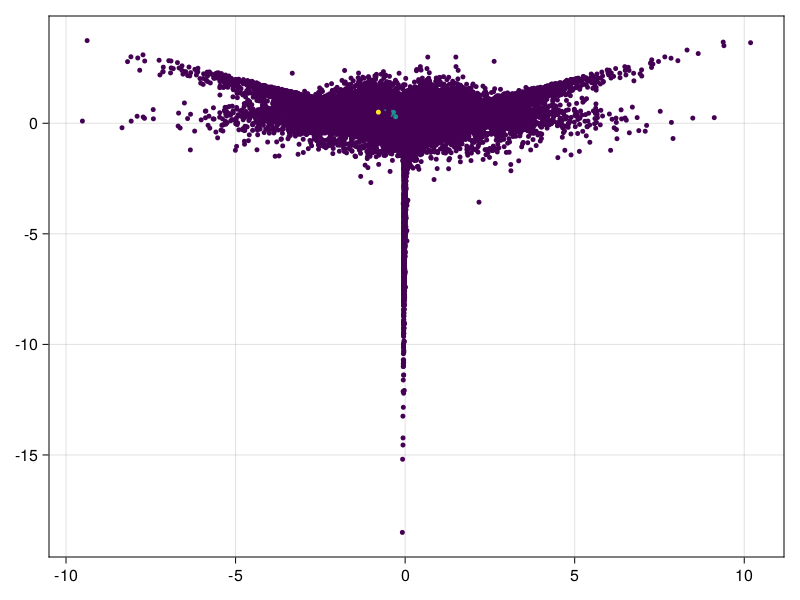

In [35]:
tree = CSV.read("data/bipartition_4taxa_tree.csv", DataFrame)
tree = standardize_tree(tree)
result = dbscan_label(tree, 0.05, min_cluster_size = 20)
plot_clusters(tree, result)

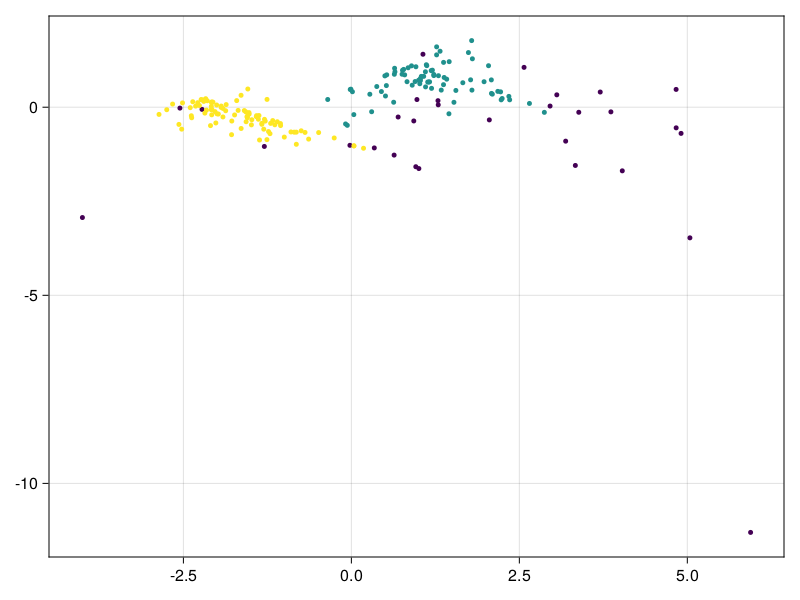

In [36]:
tree = vcat(tree_one ,tree_two)
tree = standardize_tree(tree)
label = dbscan_label(tree,0.65, min_cluster_size = 70)
plot_clusters(tree, label)

In [37]:
function remove_noise(gt, label)
    noise = Int[]
    for i in 1:length(label)
        if label[i] == 0
            push!(noise, i)
        end
    end

    counter = 0
    for i in noise
        deleteat!(gt, i-counter)
        deleteat!(label, i-counter)
        counter += 1
    end
    return gt, label
end

remove_noise (generic function with 1 method)

In [38]:
gt = ground_true(tree_one,tree_two)
gt, pred = remove_noise(gt, label)
m,x = accuracy(2, gt, pred)
display(m)
print(x)

2×2 Matrix{Int64}:
 79   1
  0  90

0.9941176470588236

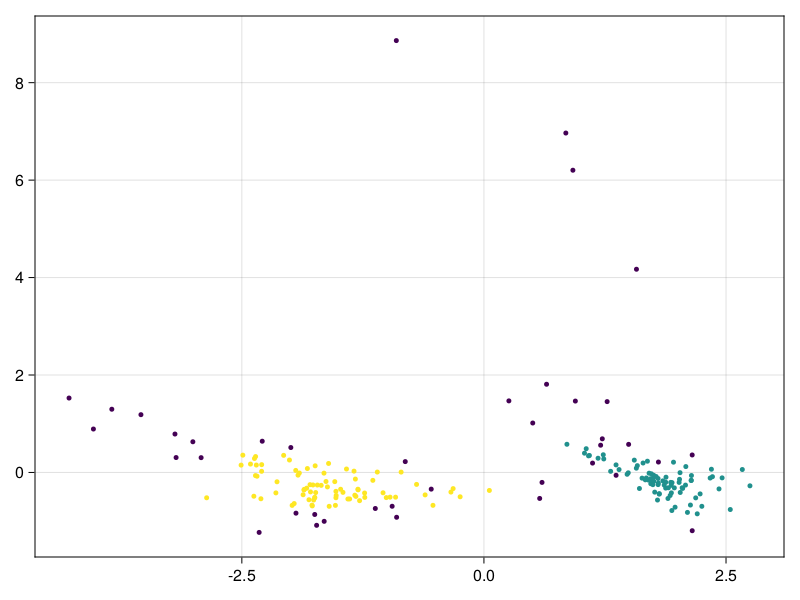

2×2 Matrix{Int64}:
 83   0
  0  78

1.0

In [133]:
gt = ground_true(tree_one,tree_three)
tree = vcat(tree_one ,tree_three)
tree = standardize_tree(tree)
label = dbscan_label(tree, 0.67,min_cluster_size = 70)
display(plot_clusters(tree, label))

gt, pred = remove_noise(gt, label)
m,x = accuracy(2, gt, pred)
display(m)
print(x)